# Reverse-Engineering the Beam Motor Packet

## Setup

In [2]:
%matplotlib inline

In [73]:
import re
import matplotlib.pyplot as plt
import array
import decimal
import itertools
import binascii

## Extract write() calls

In [4]:
write_regex = re.compile(r'\[pid \d+\] write\(33, "([x0-9a-f\\]+)"')
with open('driving_trace.txt', 'r') as trace_file:
    write_lines = [match.group(0) for match in [write_regex.match(line) for line in trace_file.readlines()] if match]

## Convert bytes to possible packet format

In [102]:
byte_regex = re.compile(r'\\x([0-9a-f]{2})')

def form_packet(byte_string):
    byte_list = [byte for byte in byte_regex.split(byte_string)[1:-1] if byte != '']
    total_bytes = bytes.fromhex(''.join((byte_list[:28])[::-1]))
    crc32 = binascii.crc32(total_bytes)
    return {
            'header': int(''.join((byte_list[:4])[::-1]), 16),
            'mode': int(''.join((byte_list[4:8])[::-1]), 16),
            'lin_vel': int(''.join((byte_list[8:12])[::-1]), 16) / 65536.0,
            'ang_vel': int(''.join((byte_list[12:16])[::-1]), 16) / 65536.0,
            'type': int(''.join((byte_list[16:20])[::-1]), 16),
            'time_tag': int(''.join((byte_list[20:28])[::-1]), 16),
            'checksum': int(''.join((byte_list[28:])[::-1]), 16),
            'crc32': crc32
           }

## Plot results to confirm conversion

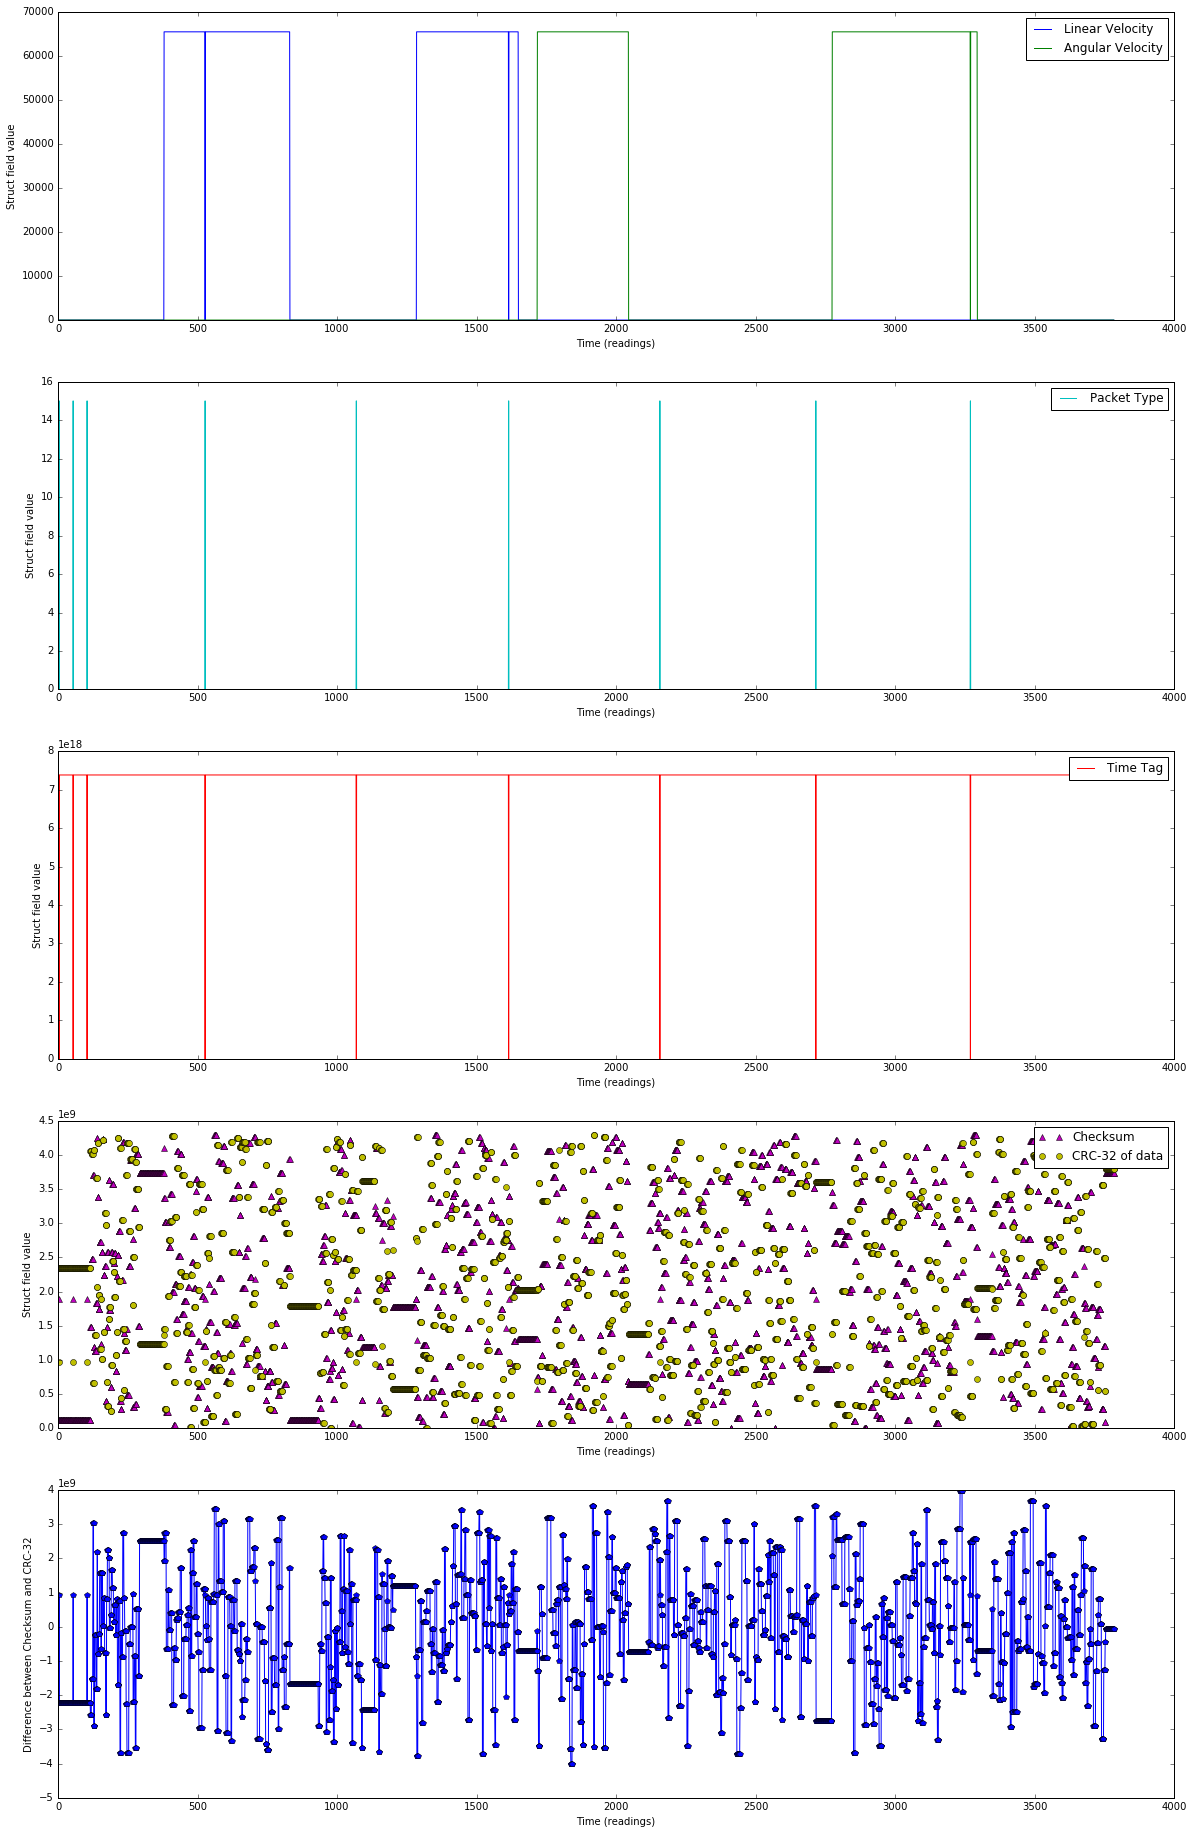

In [103]:
packet_series = [form_packet(line) for line in write_lines]
lin_vel = [packet['lin_vel'] for packet in packet_series]
ang_vel = [packet['ang_vel'] for packet in packet_series]
type_vals = [packet['type'] for packet in packet_series]
time_tag = [packet['time_tag'] for packet in packet_series]
checksum = [packet['checksum'] for packet in packet_series]
crc_vals = [packet['crc32'] for packet in packet_series]
x_vals = list(range(len(packet_series)))

plt.figure(num=None, figsize=(20, 32), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(511)
plt.plot(x_vals, lin_vel, '-b', x_vals, ang_vel, '-g')
plt.xlabel('Time (readings)')
plt.ylabel('Struct field value')
plt.legend(['Linear Velocity', 'Angular Velocity'])

plt.subplot(512)
plt.plot(x_vals, type_vals, '-c')
plt.xlabel('Time (readings)')
plt.ylabel('Struct field value')
plt.legend(['Packet Type'])

plt.subplot(513)
plt.plot(x_vals, time_tag, '-r')
plt.xlabel('Time (readings)')
plt.ylabel('Struct field value')
plt.legend(['Time Tag'])

plt.subplot(514)
plt.plot(x_vals, checksum, 'm^', x_vals, crc_vals, 'yo')
plt.xlabel('Time (readings)')
plt.ylabel('Struct field value')
plt.legend(['Checksum', 'CRC-32 of data'])

plt.subplot(515)
checkdiff = [elt[0] - elt[1] for elt in zip(checksum, crc_vals)]
plt.plot(x_vals, checkdiff, '-p')
plt.xlabel('Time (readings)')
plt.ylabel('Difference between Checksum and CRC-32')

plt.show()

## With the weird zero drops removed

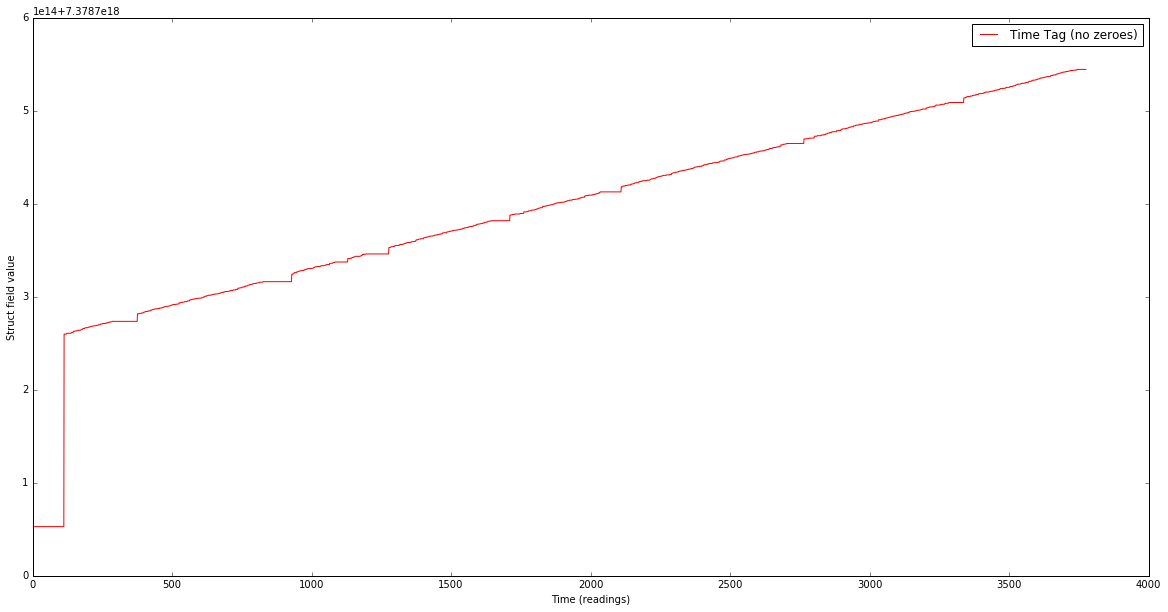

In [96]:
time_tag_nz = [value for value in time_tag if value > 0]
x_vals = range(len(time_tag_nz))

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_vals, time_tag_nz, '-r')
plt.xlabel('Time (readings)')
plt.ylabel('Struct field value')
plt.legend(['Time Tag (no zeroes)'])

plt.show()